## Prior CO2 cov matrix

* Trying out different things to create the prior CO2 uncertainty cov matrix for gradu
* Using Aki and Maria's codes for CH4 as template

In [74]:
from datetime import date
from nearestPD import nearestPD
from functions import points2distance, find_centre_region
import xarray as xr
import numpy as np
import sys

# sys.path.append('../regions/')
# sys.path.append('../pyfunc/')

#land-sea-mask_0.1x0.1deg
PATHTOMASK = '/home/pietaril/Documents/data/masks/lsm_1279l4_0.1x0.1.grb_v4_unpack.nc'
lsm = xr.open_dataset(PATHTOMASK)["lsm"][0]
today = date.today()

# Uncertainty, diagonals (std)
sigmas = {'land': 0.8,
          'ocean': 1.2} 


# Correlation length (km)
L = {'land': 100,  # 
     'ocean': 500}  # for ocean


#Finland - approx  latitude: 59.6 - 70.1, longitude: 19.3 -31.6

latmin = 59.6
latmax = 70.1
lonmin = 19.3
lonmax = 31.6

lsm = lsm.where((latmin <= lsm.latitude) & (lsm.latitude <= latmax)
          &(lonmin <= lsm.longitude)& (lsm.longitude <= lonmax), drop=True) 
lsm_flat = lsm.stack(latlon=("latitude", "longitude"))

# Output dataset
out_cov = xr.Dataset()
wfile = 'CO2_prior_cov_%04d%02d.nc' % (today.year, today.month)


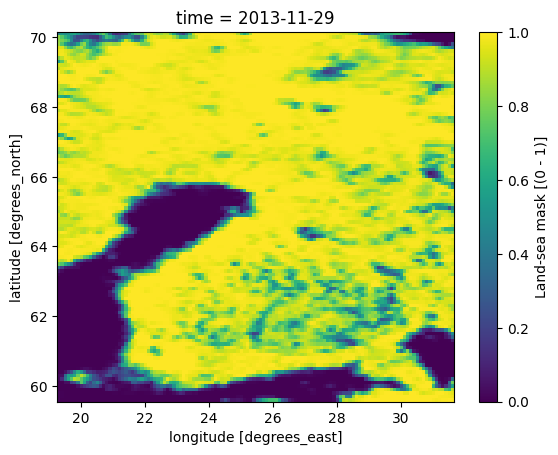

In [45]:
lsm.plot.pcolormesh()

# Let's try to make a vectorized version

* start with vectorizing points2distance-function
* Looks like chatgpt made a working one (although it does count the same distances twice and when asked not to, it resorts to nested for-loops. When asked to vectorize these, it goes back to computing distances twice and then just masking the lower triangular values to zero.)

In [82]:
def haversine_distance(coordinates):
    """
    Code created by chatGPT
    Calculate pairwise distances between points using Haversine formula.

    Parameters:
    - coordinates (ndarray): Array of (latitude, longitude) coordinates for each point.

    Returns:
    - distances (ndarray): Pairwise distances matrix.
    """

    # Earth radius in kilometers
    earth_radius = 6371.0

    # Convert latitude and longitude from degrees to radians
    lat_rad = np.radians(coordinates[:, 0])
    lon_rad = np.radians(coordinates[:, 1])

    # Compute differences in latitude and longitude
    dlat = lat_rad[:, np.newaxis] - lat_rad
    dlon = lon_rad[:, np.newaxis] - lon_rad

    # Haversine formula
    a = np.sin(dlat / 2.0) ** 2 + np.cos(lat_rad) * np.cos(lat_rad[:, np.newaxis]) * np.sin(dlon / 2.0) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    # Calculate pairwise distances in kilometers
    distances = earth_radius * c

    return distances


In [92]:
coords = np.column_stack((lsm_flat.coords["latitude"], lsm_flat.coords["longitude"]))
coords

dists = haversine_distance(coords)

In [93]:
dists

array([[   0.        ,    5.62685992,   61.89454312, ..., 1167.54672977,
        1167.55590134, 1167.5834149 ],
       [   5.62685992,    0.        ,   56.26785853, ..., 1167.55590134,
        1167.54672977, 1167.55590099],
       [  61.89454312,   56.26785853,    0.        , ..., 1168.65593193,
        1168.46350469, 1168.28937829],
       ...,
       [1167.54672977, 1167.55590134, 1168.65593193, ...,    0.        ,
           3.7848622 ,    7.56964967],
       [1167.55590134, 1167.54672977, 1168.46350469, ...,    3.7848622 ,
           0.        ,    3.78479001],
       [1167.5834149 , 1167.55590099, 1168.28937829, ...,    7.56964967,
           3.78479001,    0.        ]])

In [89]:
dists[52,187]

698.3441111901989

In [90]:
#compare to the corresponding distance computed by Aki's function
points2distance(coords[52][0], coords[52,1], coords[187][0], coords[187][1])

698.3441111901989

In [86]:
dists.shape

(13144, 13144)

In [73]:
nland

10605

In [75]:
ncount = range(0, 13100, 100)

nstate = lsm_flat.shape[0]
tresh_land = 0.5
#sort by proportion of land
lsm_flat = lsm_flat.sortby(lsm_flat, ascending=False)
lsm_flat[lsm_flat <= tresh_land] = 0
lsm_flat[lsm_flat > tresh_land] = 1
#number of land gridcells = sum of land values -1
nland = int(sum(lsm_flat.values))
cov = np.zeros((nstate, nstate))

for v in ["land", "ocean"]:
    if v == "land":
        inds = range(nland)
    else:
        inds = range(nland, nstate)
    for i in inds:
        if i in ncount:
            print(i)
        lat_i= lsm_flat["latitude"][i]
        lon_i = lsm_flat["longitude"][i]
        sigma = sigmas[v]
        l = L[v]

        # diagonal
        cov[i, i] = sigma**2

        #off-diagonals
        for j in range(inds[0],i):
            lat_j = lsm_flat["latitude"][j]
            lon_j = lsm_flat["longitude"][j]
            dist = points2distance(lat_i, lon_i, lat_j, lon_j)
            cov[i,j] = (sigma**2)*(np.exp(-1*(dist/l)))
    
i_lower = np.tril_indices(nstate, -1)
cov[i_lower] = cov.T[i_lower]









   

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600


KeyboardInterrupt: 

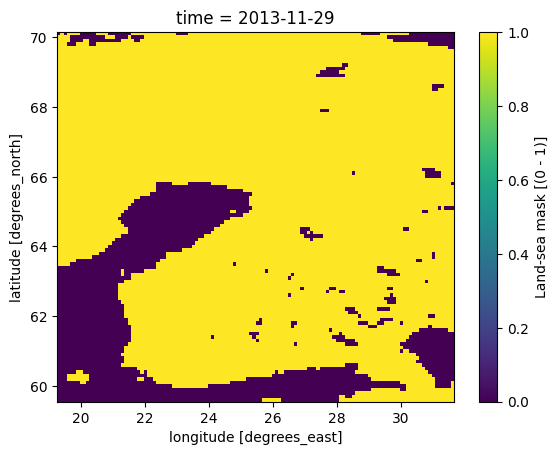

In [54]:
unstacked = lsm_flat.unstack()
unstacked.plot.pcolormesh()

In [39]:
np.arange(2)

array([0, 1])

In [38]:
lsm_flat[oce_i]

<xarray.DataArray 'lsm' ()>
array(0.)
Coordinates:
    time       datetime64[ns] 2013-11-29
    latlon     object (61.900001525878906, 25.600000381469727)
    latitude   float32 61.9
    longitude  float32 25.6
Attributes:
    units:          (0 - 1)
    long_name:      Land-sea mask
    standard_name:  land_binary_mask

In [30]:
lsm_flat_sorted

<xarray.DataArray 'lsm' (latlon: 13144)>
array([1., 1., 1., ..., 0., 0., 0.])
Coordinates:
    time       datetime64[ns] 2013-11-29
  * latlon     (latlon) object MultiIndex
  * latitude   (latlon) float32 59.6 59.6 59.6 59.6 59.6 ... 70.1 70.1 70.1 70.1
  * longitude  (latlon) float32 30.9 30.8 29.8 29.7 29.6 ... 31.0 30.9 30.8 30.7
Attributes:
    units:          (0 - 1)
    long_name:      Land-sea mask
    standard_name:  land_binary_mask

In [ ]:
 

i_lower = np.tril_indices(nr, -1) # lower triangular indices (excluding the diagonal)
cov[i_lower] = cov.T[i_lower]

cov = finalize(cov, sigmas)
dof = check(cov)
out_cov = write_dataarray(out_cov, cov, vv, nr, dof)

out_cov.to_netcdf('%s_cov.nc' % wfile.split('.nc')[0])


In [68]:
lsm_fin[:][:]

<xarray.DataArray 'lsm' (latitude: 106, longitude: 124)>
array([[4.52748997e-01, 5.28893840e-01, 4.93186639e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [8.33534250e-01, 7.40436116e-01, 6.47292204e-01, ...,
        0.00000000e+00, 9.15569255e-05, 5.18822578e-04],
       [8.39607526e-01, 7.97811789e-01, 7.56428059e-01, ...,
        3.20449239e-04, 3.35708727e-04, 3.35708727e-04],
       ...,
       [1.53357850e-02, 6.27164940e-03, 3.05189752e-05, ...,
        9.87319366e-01, 9.75310149e-01, 9.59425023e-01],
       [1.06511223e-02, 5.70704836e-03, 3.69279600e-03, ...,
        9.84969405e-01, 9.83489234e-01, 9.77202326e-01],
       [1.51984496e-02, 1.20549952e-03, 1.67854363e-04, ...,
        9.95132223e-01, 9.96459799e-01, 9.96414020e-01]])
Coordinates:
  * longitude  (longitude) float32 19.3 19.4 19.5 19.6 ... 31.3 31.4 31.5 31.6
  * latitude   (latitude) float32 70.1 70.0 69.9 69.8 ... 59.9 59.8 59.7 59.6
    time       datetime64[ns] 2013-11-29
Attributes:
    units:          (0 - 1)
    long_name:      Land-sea mask
    standard_name:  land_binary_mask

* notes on tablet on how the CH4 priors constructed

In [ ]:



region = xr.open_dataset('/home/pietaril/Documents/MI-AIM/python/PriorCovCalc/regions_verify_202011.nc')
transcom_regions = region.transcom_regions.values
ntc = transcom_regions.max()

#northern high latitudes zoom-in 1 x 1 degree
nhl = list(range(1, 7)) + [15, 16] + list(range(23, 30))
print('NHL 1x1 mTCs: ', nhl)



# Uncertainty, diagnals
sigmas = {'land': 0.8,
          'ocean': 0.2,
          'ice': 1e-8}
oce_tc = list(range(30, ntc))
ice_tc = ntc

# Correlation length (km)
L = {'land1': 100,  # for 1x1
     'land2': 500,  # for mTC
     'ocean': 900}  # for ocean

# Output dataset
out_cov = xr.Dataset()
wfile = 'regions_verify_%04d%02d.nc' % (today.year, today.month)


def sigma(tc, ntc, var, sigmas, oce_tc, ice_tc):
    out = sigmas['land'] if tc not in oce_tc else sigmas['ocean']
    if tc == ice_tc:
        out = sigmas['ice']
    return out


def latlon11(region, r, v):
    w = np.where(region['regions_%s' % v].values == r)
    latc = region.latitude.values[w[0]]
    lonc = region.longitude.values[w[1]]
    return latc, lonc


def gettc(region, j=None):
    if j == None:
        tc = np.array(list(set(region.transcom_regions.values.flatten())))
        tc = tc[~np.isnan(tc)]
    else:
        w = np.where(region['regions_%s' % v].values == j)
        tc = list(set(region.transcom_regions.values[w].flatten()))
        if len(tc) != 1:
            print('[ERROR] len(tc) not equal to 1!')
            sys.exit()
    tc = int(tc[0])
    return tc


def calc_offdiagnals11(cov, region, j, v, dregions, L):
    # off-diagonals for 1x1 areas
    latc1, lonc1 = latlon11(region, j, v)
    # off-diagnals
    for jj in dregions:
        # tämä varmaan siksi että ei kahdesti lasketa samaa off-diagonaalia
        if j >= jj:
            continue
        jj = int(jj)
        latc2, lonc2 = latlon11(region, jj, v)
        dists = points2distance(latc1, lonc1, latc2, lonc2)
        # print(j,jj, latc1,lonc1,latc2,lonc2,dists);sys.exit()
        cov[j-1, jj-1] = ((cov[j-1, j-1]**0.5) * (cov[jj-1, jj-1]**0.5)
                          * np.exp(-1*(dists/L['land1'])))
        #below the version for when stds, not vars on diagonal
        #cov[j-1, jj-1] = cov[j-1, j-1]*np.exp(-1*(dists/L['land1']))
    return cov


def istccorr(tc, tc2, nhl, oce_tc):
    # Whether tc and tc2 are correlated
    out = True
    if tc >= tc2:
        out = False
    if tc2 in nhl:
        out = False
    if tc not in oce_tc and tc2 in oce_tc:
        out = False  # no correlation between land and ocean
    if tc in oce_tc and tc2 not in oce_tc:
        out = False  # no correlation between land and ocean
    return out

def calc_offdiagnalstc(cov, tc, ntc, nhl, oce_tc, L, latc_tc, lonc_tc, region,
                       transcom_regions, v):
    #Version that Maria has fixed. Off-diagonals of TransCom areas
    for tc2 in range(1, ntc):  # do not loop through ice region
        if istccorr(tc, tc2, nhl, oce_tc):
            # correlation length
            Ld = L['land2'] if tc not in oce_tc else L['ocean']
            dists = points2distance(
                latc_tc[tc-1], lonc_tc[tc-1], latc_tc[tc2-1], lonc_tc[tc2-1])
            jj = list(set(region['regions_%s' % v].values[np.where(
                transcom_regions == tc2)].flatten()))[0]
            # print('        ',tc,tc2,j-1,ind)
            cov[j-1, jj-1] = ((cov[j-1, j-1]**0.5) * (cov[jj-1, jj-1]**0.5)
                              * np.exp(-1*(dists/Ld)))
    return cov

# alla olevassa calc_offdiagnalstc vika rivi laskettu siten kuin Akin
# mulle lähettämässä skriptissä, jossa stds diagonaalilla, ei vars

# def calc_offdiagnalstc(cov, tc, ntc, nhl, oce_tc, L, latc_tc, lonc_tc, region,
#                        transcom_regions, v):
#     for tc2 in range(1, ntc):  # do not loop through ice region
#         if istccorr(tc, tc2, nhl, oce_tc):
#             # correlation length
#             Ld = L['land2'] if tc not in oce_tc else L['ocean']
#             dists = points2distance(
#                 latc_tc[tc-1], lonc_tc[tc-1], latc_tc[tc2-1], lonc_tc[tc2-1])
#             jj = list(set(region['regions_%s' % v].values[np.where(
#                 transcom_regions == tc2)].flatten()))[0]
#             # print('        ',tc,tc2,j-1,ind)
#             cov[j-1, jj-1] = cov[j-1, j-1]*np.exp(-1*(dists/Ld))
#     return cov


def finalize(cov, sigmas):
    # If matrix is not positive definite, take nearest PD
    try:
        # C = np.linalg.cholesky(cov)
        np.linalg.cholesky(cov)

    except:
        print('Maxrix not positive definite. Take nearest PD.')
        # The matrix is probably not postive definite
        cov = nearestPD(cov)
        cov[-1, -1] = sigmas['ice']  # ice, make sure it's same as defined
    return cov


def check(cov):
    dof = 0
    # test
    try:
        C = np.linalg.cholesky(cov)
        _, s, _ = np.linalg.svd(cov)
        dof = np.sum(s) ** 2 / sum(s ** 2)
        print('Approx. dof:', int(dof))
    except:
        print('[ERROR] Matrix not positive definite!')
        sys.exit()
    return dof


def write_dataarray(data, cov, v, nr, dof):
    data['covariance_%s' % v] = xr.DataArray(
        data=cov,
        dims=['nparams_%s' % v, 'nparams_%s' % v],
        coords={'nparams_%s' % v: np.arange(
            nr), 'nparams_%s' % v: np.arange(nr)},
        attrs={
            'comment': "Prior covariance for %s fluxes. Approx. dof = %s" % (v, int(dof))}
    )
    return data


ncount = range(0, 7000, 100)
for vv in ['bio', 'anth', 'anth2']:
    v = 'bio' if vv == 'bio' else 'anth'
    print('Create covariance for ', v)

    nr = region['regions_%s' % v].values.max() #6858
    cov = np.zeros((nr, nr))
    categ = region['regions_%s_categ' % v]

    for i in set(categ.values.flatten()):
        print('  categ: ', i)
        # filter variables in dataset "region" so that everything for which categ not i is set to nan
        dummy = region.where(categ == i, drop=True)
        # get tc corresponding to categ i
        tc = gettc(dummy, None)

        if v == 'bio' and tc in oce_tc:
            print(tc)
            continue  # do not optimize ocean flux for bio
        
        #filter optimization regions corresponding to categ i
        dregions = dummy['regions_%s' % v].values.flatten()
        dregions = set(dregions[~np.isnan(dregions)])

        for j in dregions:
            j = int(j)
            if j in ncount:
                print(j)

            # diagnals
            tc = gettc(dummy, j)
            # j-1 because opt regions numbering starts from 1 -> conversion to 0-based indexing
            cov[j-1, j-1] = sigma(tc, ntc, v, sigmas, oce_tc,
                                  ice_tc)**2
            if tc == ice_tc:
                print('        Ice. Independent of any other regions')
                continue

            if vv == 'anth2':
                continue  # no correlation at all
            # off-diagnals
            if i == 0:  # 1x1
                cov = calc_offdiagnals11(cov, dummy, j, v, dregions, L)
            else:  # mTCs
                if v == 'anth':
                    continue  # no correlation over mTCs in anth
                cov = calc_offdiagnalstc(
                    cov, tc, ntc, nhl, oce_tc, L, latc_tc, lonc_tc, region, transcom_regions, v)
            #break
        #break
    #break

    i_lower = np.tril_indices(nr, -1) # lower triangular indices (excluding the diagonal)
    cov[i_lower] = cov.T[i_lower]

    cov = finalize(cov, sigmas)
    dof = check(cov)
    out_cov = write_dataarray(out_cov, cov, vv, nr, dof)

out_cov.to_netcdf('%s_cov.nc' % wfile.split('.nc')[0])
